In [9]:
import numpy as np
from scipy.optimize import fsolve
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
import matplotlib.pyplot as plt

# ODEs for the posneg circuit
def Equ1(x, y, beta_x, n):
    """
    Compute the first ODE: dx/dt = beta_x / (1 + y^n) - x.

    Args:
        x (float): State variable x.
        y (float): State variable y.
        beta_x (float): Parameter controlling production rate of x.
        n (float): Parameter controlling nonlinearity.

    Returns:
        float: Value of dx/dt.
    """
    return beta_x / (1 + y**n) - x

def Equ2(x, y, beta_y, n):
    """
    Compute the second ODE: dy/dt = beta_y * x^n / (1 + x^n) - y.

    Args:
        x (float): State variable x.
        y (float): State variable y.
        beta_y (float): Parameter controlling production rate of y.
        n (float): Parameter controlling nonlinearity.

    Returns:
        float: Value of dy/dt.
    """
    return beta_y * x**n / (1 + x**n) - y

def Equs(P, t, params):
    """
    Evaluate the vector field for the ODE system.

    Args:
        P (array): State vector [x, y].
        t (float): Time (unused, as ODE is autonomous).
        params (array): Parameters [beta_x, beta_y, n].

    Returns:
        array: ODE values [dx/dt, dy/dt].
    """
    x, y = P
    beta_x, beta_y, n = params
    return np.array([Equ1(x, y, beta_x, n), Equ2(x, y, beta_y, n)])

# Sensitivity functions
def S_betax_xss_analytic(xss, yss, beta_x, beta_y, n):
    """
    Calculate sensitivity of xss to beta_x.

    Args:
        xss (float): Steady state value of x.
        yss (float): Steady state value of y.
        beta_x (float): Parameter beta_x.
        beta_y (float): Parameter beta_y.
        n (float): Parameter n.

    Returns:
        float: Absolute value of sensitivity.
    """
    numer = beta_x * (1 + xss**n) * (1 + yss**n)
    denom = n**2 * beta_x * yss**n + xss * (1 + yss**n)**2 + xss**(1+n) * (1 + yss**n)**2
    return abs(numer / denom)

def S_n_xss_analytic(xss, yss, beta_x, beta_y, n):
    """
    Calculate sensitivity of xss to n.

    Args:
        xss (float): Steady state value of x.
        yss (float): Steady state value of y.
        beta_x (float): Parameter beta_x.
        beta_y (float): Parameter beta_y.
        n (float): Parameter n.

    Returns:
        float: Absolute value of sensitivity.
    """
    numer = n * beta_x * (n * np.log(xss) + np.log(yss) + np.log(yss) * xss**n) * yss**n
    denom = n**2 * beta_x * yss**n + xss * (1 + yss**n)**2 + xss**(1+n) * (1 + yss**n)**2
    return abs(-numer / denom)

# Initial guesses for steady state
def generate_initial_guesses(beta_x_val, beta_y_val):
    """
    Provide initial guesses for solving the ODE system.

    Args:
        beta_x_val (float): Value of beta_x.
        beta_y_val (float): Value of beta_y.

    Returns:
        list: List of initial guess arrays [x, y].
    """
    return [
        np.array([1, 1]),
        np.array([0, 0]),
        np.array([0.3, 12.5]),
        np.array([50.5, 0.9]),
        np.array([67.6, 0.9]),
        np.array([21, 0.9])
    ]

def ssfinder(beta_x_val, beta_y_val, n_val):
    """
    Find the steady state (xss, yss) for given beta_x, beta_y, and n.

    Args:
        beta_x_val (float): Value of beta_x.
        beta_y_val (float): Value of beta_y.
        n_val (float): Value of n.

    Returns:
        tuple: (xss, yss) if valid, else (np.nan, np.nan).
    """
    params = np.array([beta_x_val, beta_y_val, n_val])
    for init_guess in generate_initial_guesses(beta_x_val, beta_y_val):
        # Solve ODE system using fsolve
        output, infodict, intflag, _ = fsolve(
            Equs, init_guess, args=(0, params), xtol=1e-12, full_output=True
        )
        xss, yss = output
        fvec = infodict['fvec']
        # Check stability via Jacobian eigenvalues
        delta = 1e-8
        dEqudx = (Equs([xss + delta, yss], 0, params) - Equs([xss, yss], 0, params)) / delta
        dEqudy = (Equs([xss, yss + delta], 0, params) - Equs([xss, yss], 0, params)) / delta
        jac = np.transpose(np.vstack((dEqudx, dEqudy)))
        eig = np.linalg.eig(jac)[0]
        instability = np.any(np.real(eig) >= 0)
        # Validate solution: positive, small residual, stable, and converged
        if (xss > 0.04 and yss > 0.04 and np.linalg.norm(fvec) < 1e-10 and
                intflag == 1 and not instability):
            return xss, yss
    return np.nan, np.nan

class Sensitivity(ElementwiseProblem):
    """
    Define the multi-objective optimization problem to minimize sensitivities.

    Optimizes beta_x, beta_y, and n to minimize S_betax_xss and S_n_xss.
    """
    def __init__(self):
        super().__init__(
            n_var=3,  # Variables: beta_x, beta_y, n
            n_obj=2,  # Objectives: S_betax_xss, S_n_xss
            n_constr=0,
            xl=np.array([0.001, 0.001, 0.001]),  # Lower bounds
            xu=np.array([50.0, 50.0, 10.0])      # Upper bounds
        )

    def _evaluate(self, x, out, *args, **kwargs):
        """
        Evaluate the objectives for a given (beta_x, beta_y, n) set.

        Args:
            x (array): Parameter vector [beta_x, beta_y, n].
            out (dict): Dictionary to store objective values.
        """
        beta_x, beta_y, n = x
        xss, yss = ssfinder(beta_x, beta_y, n)
        if np.isnan(xss) or np.isnan(yss):
            out["F"] = [1e5, 1e5]  # Penalize invalid solutions
        else:
            out["F"] = [
                S_betax_xss_analytic(xss, yss, beta_x, beta_y, n),
                S_n_xss_analytic(xss, yss, beta_x, beta_y, n)
            ]

# Run NSGA-II optimization
algorithm = NSGA2(pop_size=1000)  # Population size
res = minimize(
    Sensitivity(),
    algorithm,
    ('n_gen', 200),  # Number of generations
    seed=1,
    verbose=True
)


/tmp/ipykernel_300050/2469687295.py:37: RuntimeWarning: invalid value encountered in scalar power
  return beta_y * x**n / (1 + x**n) - y
/tmp/ipykernel_300050/2469687295.py:22: RuntimeWarning: invalid value encountered in scalar power
  return beta_x / (1 + y**n) - x


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |     1000 |     17 |             - |             -
     2 |     2000 |     25 |  0.0167930540 |             f
     3 |     3000 |     34 |  0.0076148595 |             f
     4 |     4000 |     52 |  0.0087210084 |             f
     5 |     5000 |     67 |  0.0064956321 |         nadir
     6 |     6000 |     99 |  0.0037683818 |             f
     7 |     7000 |    123 |  0.0124060941 |         nadir
     8 |     8000 |    172 |  0.0017203399 |             f
     9 |     9000 |    206 |  0.0027493492 |             f
    10 |    10000 |    257 |  0.0051634687 |         nadir
    11 |    11000 |    329 |  0.0007755093 |             f
    12 |    12000 |    420 |  0.0011805228 |             f
    13 |    13000 |    527 |  0.0013939080 |             f
    14 |    14000 |    656 |  0.0014469375 |             f
    15 |    15000 |    788 |  0.0015458533 |             f
    16 |    16000 |    938 |  0.0016214863 |            

Found 1000 non-dominated points in 54.460s


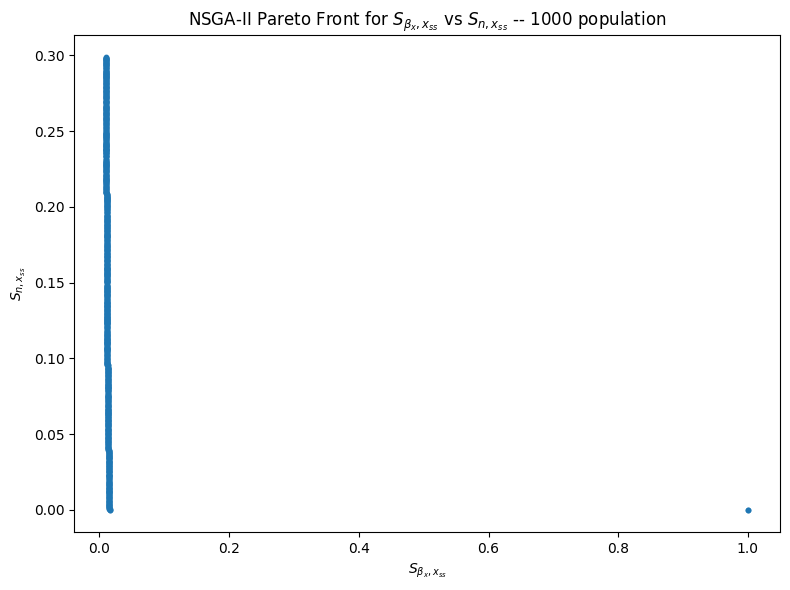

In [10]:


F = res.F  # Objective values (sensitivities)
X = res.X  # Parameter values (beta_x, beta_y, n)
print(f"Found {F.shape[0]} non-dominated points in {res.exec_time:.3f}s")

plt.figure(figsize=(8, 6))
plt.scatter(F[:, 0], F[:, 1], s=10)
plt.xlabel(r'$S_{\beta_x,x_{ss}}$')  # Sensitivity of xss to beta_x
plt.ylabel(r'$S_{n,x_{ss}}$')  # Sensitivity of xss to n
plt.title(r'NSGA-II Pareto Front for $S_{\beta_x,x_{ss}}$ vs $S_{n,x_{ss}}$ -- 1000 population')
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

F = res.F          # shape: (k, 2)  -> [S_alpha, S_n]
X = res.X          # shape: (k, 2)  -> [alpha, n]

# Drop any penalized or NaN rows (you used 1e5 as penalty)
mask_ok = np.isfinite(F).all(axis=1) & (F < 1e5).all(axis=1)
F_ok, X_ok = F[mask_ok], X[mask_ok]

# Recompute the true non-dominated front (paranoid but safe)
I = NonDominatedSorting().do(F_ok, only_non_dominated_front=True)
F_nd, X_nd = F_ok[I], X_ok[I]

# Save only the front points (objectives) as .npy
np.save("/home/m3-learning/Downloads/SA/Genetic Algorithms for Multi-Objective Optimization/Arrays for Generational Distance calculation/PosNeg_0v4_F_NSGA-II_2000.npy", F_nd)

# Or save both objectives and decisions in one compressed .npz
np.savez_compressed("/home/m3-learning/Downloads/SA/Genetic Algorithms for Multi-Objective Optimization/Arrays for Generational Distance calculation/PosNeg_0v4_Pareto_front_and_X_NSGA-II_2000.npz", F=F_nd, X=X_nd)

